
# Chapter 12


<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/phonchi/nsysu-math524/blob/main/static_files/presentations/Ch12-unsup-lab-zh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/phonchi/nsysu-math524/blob/main/static_files/presentations/Ch12-unsup-lab-zh.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>


In [ ]:
%load_ext cudf.pandas
%load_ext cuml.accel

In [2]:
%pip install ISLP -qq
%pip install fancyimpute -qq
%pip install opentsne -qq
%pip install umap-learn -qq
%pip install git+https://github.com/dmuellner/fastcluster -qq
%pip install hdbscan -qq
%pip install phate -qq

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 831.6/831.6 kB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 13.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.9/52.9 kB 2.0 MB/

In [1]:
# 本 Notebook 使用的匯入（imports）
import numpy as np  # 數值運算與陣列處理
import pandas as pd  # 資料表格與資料處理
import seaborn as sns  # 統計視覺化
import matplotlib.pyplot as plt  # 繪圖指令與樣式
from matplotlib.pyplot import subplots  # 建立子圖與繪圖版面
from sklearn.preprocessing import StandardScaler  # 特徵標準化
from sklearn.decomposition import PCA  # 主成分分析 (PCA)
from sklearn.manifold import TSNE  # t-SNE 降維
from openTSNE import TSNE as oTSNE  # openTSNE 版本的 t-SNE
import umap  # UMAP 降維
import phate  # PHATE 降維
from sklearn.cluster import (  # 聚類演算法
    KMeans, AgglomerativeClustering, DBSCAN
)
from scipy.cluster.hierarchy import (  # 階層式聚類工具
    linkage, dendrogram, cut_tree
)
from sklearn.datasets import load_digits, make_blobs  # 範例/合成資料集
from sklearn.model_selection import train_test_split  # 訓練/測試切分
from sklearn.neighbors import KNeighborsClassifier  # KNN 分類器
from sklearn.svm import SVC  # 支援向量機 (SVC)
from sklearn import metrics  # 評估（silhouette/CH/DB/ARI/NMI 等）
from sklearn.metrics import adjusted_rand_score  # ARI 指標（直接使用名稱）
from ISLP import load_data  # ISLP 資料載入
from ISLP.cluster import compute_linkage  # ISLP 階層式聚類：快速連結計算
import fastcluster as fc  # fastcluster 加速
import hdbscan  # HDBSCAN 聚類
from fancyimpute import SoftImpute  # 缺失值補全（矩陣分解）
from statsmodels.datasets import get_rdataset  # 讀取 R 資料集
from itertools import islice, cycle

/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


# 實驗：無監督學習（Unsupervised Learning）

我們在頂層匯入一些常用的函式庫。

在本實驗中，我們將示範在數個資料集上進行PCA（主成分分析）和聚類分析（clustering）。

如同其他實驗，我們在頂層匯入一些常用的函式庫。這讓程式碼更具可讀性，因為透過掃描notebook的前幾行，我們就能知道此notebook中使用了哪些函式庫。

In [2]:
%matplotlib inline
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

## 主成分分析（Principal Components Analysis）

在本實驗中，我們對[`USArrests`](https://islp.readthedocs.io/en/latest/datasets/USArrests.html#notes)資料集進行PCA，這是`R`計算環境中的一個資料集。我們使用`get_rdataset()`來取得資料，此函數可以從許多標準的`R`套件中讀取資料。

該資料集的行包含50個州，按字母順序排列。

In [3]:
USArrests = get_rdataset('USArrests').data
USArrests

,Murder,Assault,UrbanPop,Rape
rownames,,,,
Alabama,13.2,236,58,21.2
Alaska,10.0,263,48,44.5
Arizona,8.1,294,80,31.0
Arkansas,8.8,190,50,19.5
California,9.0,276,91,40.6
Colorado,7.9,204,78,38.7
Connecticut,3.3,110,77,11.1
Delaware,5.9,238,72,15.8
Florida,15.4,335,80,31.9


該資料集的列包含四個變數。

In [4]:
USArrests.columns

Index(['Murder', 'Assault', 'UrbanPop', 'Rape'], dtype='object')

我們首先簡單檢視資料。我們注意到各變數具有截然不同的均值。

In [5]:
USArrests.mean()

,0
Murder,7.788
Assault,170.760
UrbanPop,65.540
Rape,21.232


Dataframes有數個有用的方法來計算
逐列摘要統計。我們也可以使用`var()`方法來檢視
四個變數的變異數。

In [6]:
USArrests.var()

,0
Murder,18.970465
Assault,6945.165714
UrbanPop,209.518776
Rape,87.729159


不出所料，各變數也有截然不同的變異數。
`UrbanPop`變數測量每個州居住在城市地區的人口百分比，這與每個州每10萬人口中的強姦案件數量並不具可比性。
PCA尋找能夠解釋資料集中最多變異數的衍生變數。
如果我們在執行PCA之前不對變數進行標準化，那麼主成分將主要由
`Assault`變數驅動，因為它具有最大的
變異數。因此，如果變數以不同的單位測量或在尺度上變化很大，建議在執行PCA之前將變數標準化為具有標準差為1。
通常我們也會將均值設為零。

這種標準化可以透過上面匯入的`StandardScaler()`轉換來完成。我們首先`fit`（擬合）
縮放器，它計算必要的均值和標準差，然後使用
`transform`方法將其應用於我們的資料。如之前一樣，我們使用`fit_transform()`方法來結合這些步驟。

In [7]:
scaler = StandardScaler(with_std=True,
                        with_mean=True)
USArrests_scaled = scaler.fit_transform(USArrests)

完成資料標準化後，我們接著可以
使用`scikit-learn.decomposition`套件中的`PCA()`轉換
來執行主成分分析。

In [8]:
pcaUS = PCA()

（預設情況下，`PCA()`轉換會將變數置中到均值為零，但不會縮放它們。）轉換器`pcaUS`
可以用來尋找PCA
`scores`，這些分數由`fit()`方法回傳。一旦呼叫了`fit`方法，`pcaUS`物件也會包含許多有用的數量。

In [9]:
pcaUS.fit(USArrests_scaled)

PCA()

擬合後，`mean_`屬性對應於變數的均值。在這種情況下，由於我們使用`scaler()`對資料進行了置中和縮放，所以均值都將為0。

In [10]:
pcaUS.mean_

array([-7.10542736e-17,  1.38777878e-16, -4.39648318e-16,  8.59312621e-16])

分數可以在擬合後使用`pcaUS`的`transform()`方法來計算。

In [11]:
scores = pcaUS.transform(USArrests_scaled)

我們將在下面進一步繪製這些分數。
`components_`屬性提供主成分負載：
`pcaUS.components_`的每一行都包含對應的
主成分負載向量。

In [12]:
pcaUS.components_

array([[ 0.53589947,  0.58318363,  0.27819087,  0.54343209],
       [-0.41818087, -0.1879856 ,  0.87280619,  0.16731864],
       [-0.34123273, -0.26814843, -0.37801579,  0.81777791],
       [-0.6492278 ,  0.74340748, -0.13387773, -0.08902432]])

雙標圖（`biplot`）是PCA常用的視覺化方法。這並非`scikit-learn`的標準內建功能，儘管有Python套件能產生這樣的圖表。在這裡我們
手動製作簡單的雙標圖。

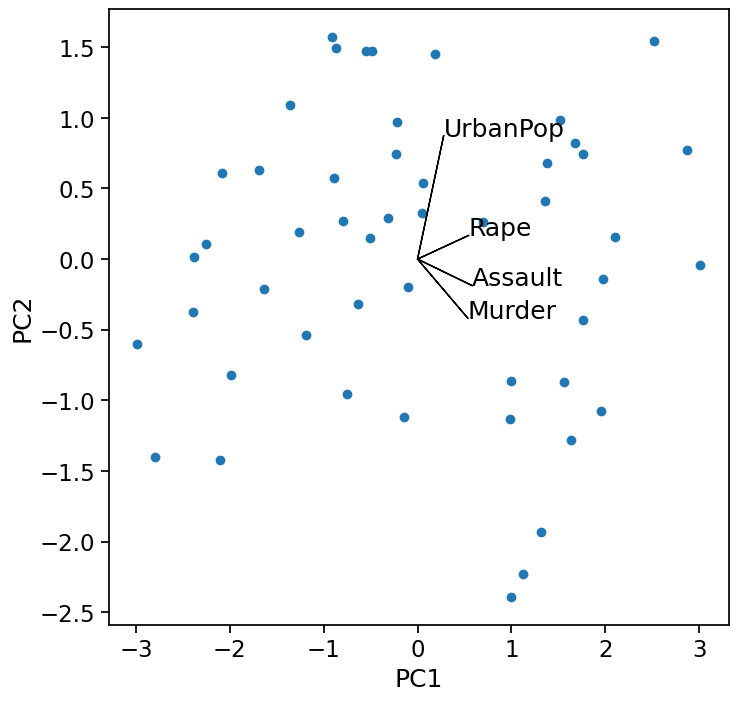

In [13]:
i, j = 0, 1 # which components
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(scores[:,0], scores[:,1])
ax.set_xlabel('PC%d' % (i+1))
ax.set_ylabel('PC%d' % (j+1))
for k in range(pcaUS.components_.shape[1]):
    ax.arrow(0, 0, pcaUS.components_[i,k], pcaUS.components_[j,k])
    ax.text(pcaUS.components_[i,k],
            pcaUS.components_[j,k],
            USArrests.columns[k])

注意這個圖形是圖12.1通過$y$軸的反射。回想起
主成分只在符號變化上是唯一的，所以我們可以
通過翻轉第二組分數和負載的符號來重現該圖形。
我們也增加箭頭的長度來強調負載。

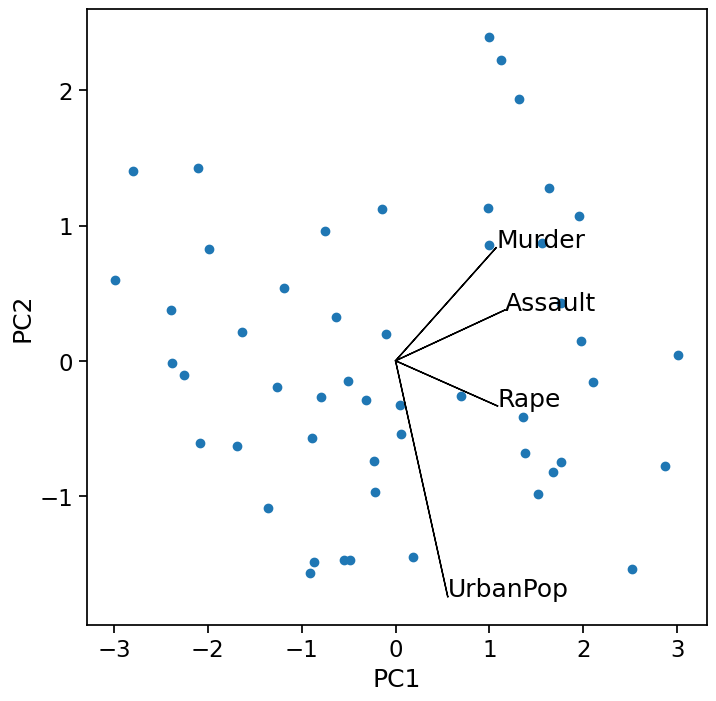

In [14]:
scale_arrow = s_ = 2
scores[:,1] *= -1
pcaUS.components_[1] *= -1 # flip the y-axis
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(scores[:,0], scores[:,1])
ax.set_xlabel('PC%d' % (i+1))
ax.set_ylabel('PC%d' % (j+1))
for k in range(pcaUS.components_.shape[1]):
    ax.arrow(0, 0, s_*pcaUS.components_[i,k], s_*pcaUS.components_[j,k])
    ax.text(s_*pcaUS.components_[i,k],
            s_*pcaUS.components_[j,k],
            USArrests.columns[k])

主成分分數的標準差如下：

In [15]:
scores.std(0, ddof=1)

array([1.5908673 , 1.00496987, 0.6031915 , 0.4206774 ])

每個分數的變異數可以透過
`explained_variance_`屬性直接從`pcaUS`物件中提取。

In [16]:
pcaUS.explained_variance_

array([2.53085875, 1.00996444, 0.36383998, 0.17696948])

每個主成分解釋的變異數比例（PVE）儲存在`explained_variance_ratio_`中：

In [17]:
pcaUS.explained_variance_ratio_

array([0.62006039, 0.24744129, 0.0891408 , 0.04335752])

我們看到第一個主成分解釋了資料中62.0%的變異數，下一個主成分解釋了24.7%的變異數，依此類推。
我們可以繪製每個成分解釋的PVE，以及累積PVE。我們首先
繪製解釋的變異數比例。

In [18]:
%%capture
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
ticks = np.arange(pcaUS.n_components_)+1
ax = axes[0]
ax.plot(ticks,
        pcaUS.explained_variance_ratio_,
        marker='o')
ax.set_xlabel('Principal Component');
ax.set_ylabel('Proportion of Variance Explained')
ax.set_ylim([0,1])
ax.set_xticks(ticks)

注意使用`%%capture`，這會抑制部分完成圖形的顯示。

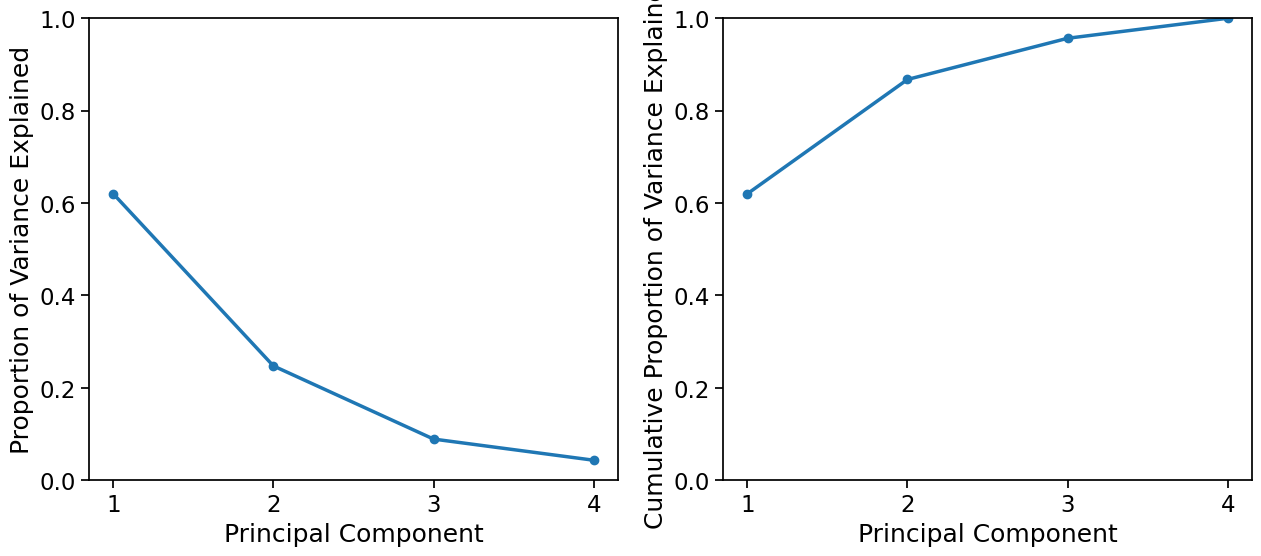

In [19]:
ax = axes[1]
ax.plot(ticks,
        pcaUS.explained_variance_ratio_.cumsum(),
        marker='o')
ax.set_xlabel('Principal Component')
ax.set_ylabel('Cumulative Proportion of Variance Explained')
ax.set_ylim([0, 1])
ax.set_xticks(ticks)
fig

結果與圖12.3所示相似。注意
`cumsum()`方法計算數值向量元素的累積和。例如：

In [20]:
a = np.array([1,2,8,-3])
np.cumsum(a)

array([ 1,  3, 11,  8])

## 矩陣補全（Matrix Completion）

我們現在重新創建在第12.3節中對`USArrests`資料進行的分析。

我們在第12.2.2節中看到，在置中的資料矩陣$\bf X$上求解最佳化
問題(12.6)等價於計算資料的前$M$個主成分。我們使用下面我們標準化和置中的`USArrests`資料作為$\bf X$。奇異值分解（*singular value decomposition*, SVD）是求解(12.6)的一般演算法。

In [21]:
X = USArrests_scaled
U, D, V = np.linalg.svd(X, full_matrices=False)
U.shape, D.shape, V.shape

((50, 4), (4,), (4, 4))

`np.linalg.svd()`函數回傳三個組件：`U`、`D`和`V`。矩陣`V`等價於主成分的負載矩陣（除了不重要的符號翻轉）。使用`full_matrices=False`選項確保對於高矩陣，`U`的形狀與`X`的形狀相同。

In [22]:
V

array([[-0.53589947, -0.58318363, -0.27819087, -0.54343209],
       [-0.41818087, -0.1879856 ,  0.87280619,  0.16731864],
       [ 0.34123273,  0.26814843,  0.37801579, -0.81777791],
       [ 0.6492278 , -0.74340748,  0.13387773,  0.08902432]])

In [23]:
pcaUS.components_

array([[ 0.53589947,  0.58318363,  0.27819087,  0.54343209],
       [ 0.41818087,  0.1879856 , -0.87280619, -0.16731864],
       [-0.34123273, -0.26814843, -0.37801579,  0.81777791],
       [-0.6492278 ,  0.74340748, -0.13387773, -0.08902432]])

矩陣`U`對應於PCA分數矩陣的*標準化*版本（每列標準化為平方和為1）。如果我們將`U`的每列乘以`D`的對應元素，我們就能精確地恢復PCA分數（除了無意義的符號翻轉）。

In [24]:
(U * D[None,:])[:3]

array([[-0.98556588, -1.13339238,  0.44426879,  0.15626714],
       [-1.95013775, -1.07321326, -2.04000333, -0.43858344],
       [-1.76316354,  0.74595678, -0.05478082, -0.83465292]])

In [25]:
scores[:3]

array([[ 0.98556588,  1.13339238, -0.44426879, -0.15626714],
       [ 1.95013775,  1.07321326,  2.04000333,  0.43858344],
       [ 1.76316354, -0.74595678,  0.05478082,  0.83465292]])

雖然使用`PCA()`估計器來進行此實驗是可能的，
在這裡我們使用`np.linalg.svd()`函數以說明其使用方法。

我們現在隨機省略$50\times 4$資料矩陣中的20個項目。我們首先隨機選擇20行（州），然後在每行中隨機選取四個項目中的一個。這確保每行至少有三個觀察值。

In [26]:
n_omit = 20
np.random.seed(15)
r_idx = np.random.choice(np.arange(X.shape[0]),
                         n_omit,
                         replace=False)
c_idx = np.random.choice(np.arange(X.shape[1]),
                         n_omit,
                         replace=True)
Xna = X.copy()
Xna[r_idx, c_idx] = np.nan

這裡陣列`r_idx`包含從0到49的20個整數；這代表被選中包含缺失值的州（`X`的行）。而`c_idx`包含從0到3的20個整數，代表每個選定州中包含缺失值的特徵（`X`中的列）。

我們現在編寫一些程式碼來實現演算法12.1。
我們首先編寫一個函數，它接受一個矩陣，並使用`svd()`函數回傳該矩陣的近似值。
這將在演算法12.1的步驟2中需要。

In [27]:
def low_rank(X, M=1):
    U, D, V = np.linalg.svd(X)
    L = U[:,:M] * D[None,:M]
    return L.dot(V[:M])

為執行演算法的步驟1，我們初始化`Xhat`——這是演算法12.1中的$\tilde{\bf X}$——透過用非缺失項目的列均值來替代缺失值。這些均值在對行軸運行`np.nanmean()`後儲存在下面的`Xbar`中。
我們製作一個副本，以便當我們在下面給`Xhat`賦值時，不會同時覆蓋`Xna`中的值。

In [28]:
Xhat = Xna.copy()
Xbar = np.nanmean(Xhat, axis=0)
Xhat[r_idx, c_idx] = Xbar[c_idx]

在我們開始步驟2之前，我們設置來測量迭代的
進度：

In [29]:
thresh = 1e-7
rel_err = 1
count = 0
ismiss = np.isnan(Xna)
mssold = np.mean(Xhat[~ismiss]**2)
mss0 = np.mean(Xna[~ismiss]**2)

這裡`ismiss`是一個與`Xna`具有相同維度的邏輯矩陣；
如果對應的矩陣元素缺失，給定元素為`True`。記號`~ismiss`否定此布林向量。這很有用，因為它允許我們存取缺失和非缺失的項目。我們將非缺失元素的平方均值儲存在`mss0`中。
我們將舊版本`Xhat`的非缺失元素的均方誤差（MSE）儲存在`mssold`中（目前與`mss0`一致）。我們計劃將當前版本`Xhat`的非缺失元素的均方誤差（MSE）儲存在`mss`中，然後迭代演算法12.1的步驟2，直到*相對誤差*（定義為`(mssold - mss) / mss0`）低於`thresh = 1e-7`。
 {演算法12.1告訴我們迭代步驟2直到(12.14)不再減少。判斷(12.14)是否在減少只需要我們追蹤`mssold - mss`。然而，在實際中，我們追蹤`(mssold - mss) / mss0`：這使得演算法12.1收斂所需的迭代次數不依賴於我們是否將原始資料$\bf X$乘以常數因子。}

在演算法12.1的步驟2(a)中，我們使用`low_rank()`來近似`Xhat`；我們稱之為`Xapp`。在步驟2(b)中，我們使用`Xapp`來更新`Xhat`中在`Xna`中缺失的元素的估計值。最後，在步驟2(c)中，我們計算相對誤差。這三個步驟包含在以下`while`迴圈中：

In [30]:
while rel_err > thresh:
    count += 1
    # Step 2(a)
    Xapp = low_rank(Xhat, M=1)
    # Step 2(b)
    Xhat[ismiss] = Xapp[ismiss]
    # Step 2(c)
    mss = np.mean(((Xna - Xapp)[~ismiss])**2)
    rel_err = (mssold - mss) / mss0
    mssold = mss
    print("Iteration: {0}, MSS:{1:.3f}, Rel.Err {2:.2e}"
          .format(count, mss, rel_err))

Iteration: 1, MSS:0.395, Rel.Err 5.99e-01
Iteration: 2, MSS:0.382, Rel.Err 1.33e-02
Iteration: 3, MSS:0.381, Rel.Err 1.44e-03
Iteration: 4, MSS:0.381, Rel.Err 1.79e-04
Iteration: 5, MSS:0.381, Rel.Err 2.58e-05
Iteration: 6, MSS:0.381, Rel.Err 4.22e-06
Iteration: 7, MSS:0.381, Rel.Err 7.65e-07
Iteration: 8, MSS:0.381, Rel.Err 1.48e-07
Iteration: 9, MSS:0.381, Rel.Err 2.95e-08


我們看到經過八次迭代後，相對誤差已降到`thresh = 1e-7`以下，因此演算法終止。發生這種情況時，非缺失元素的均方誤差（MSE）等於0.381。

最後，我們計算20個插補值與實際值之間的相關性：

In [31]:
np.corrcoef(Xapp[ismiss], X[ismiss])[0,1]

np.float64(0.7113567434297361)

在本實驗中，我們為了教學目的自行實現了演算法12.1。然而，希望將矩陣補全應用於其資料的讀者可能會尋求更專業的Python實作。在實際中，如果我們希望將矩陣補全應用於我們的
資料，我們可以使用 https://github.com/iskandr/fancyimpute 套件，它提供此演算法的非常高效的實作和推廣。

In [32]:
Xhat2 = Xna.copy()
X_filled = SoftImpute(max_rank=1).fit_transform(Xhat2)

[SoftImpute] Max Singular Value of X_init = 10.051477
[SoftImpute] Iter 1: observed MAE=0.471764 rank=1
[SoftImpute] Iter 2: observed MAE=0.456110 rank=1
[SoftImpute] Iter 3: observed MAE=0.454752 rank=1
[SoftImpute] Iter 4: observed MAE=0.454356 rank=1
[SoftImpute] Iter 5: observed MAE=0.454261 rank=1
[SoftImpute] Iter 6: observed MAE=0.454227 rank=1
[SoftImpute] Iter 7: observed MAE=0.454210 rank=1
[SoftImpute] Iter 8: observed MAE=0.454202 rank=1
[SoftImpute] Stopped after iteration 8 for lambda=0.201030


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [33]:
np.corrcoef(X_filled[ismiss], X[ismiss])[0,1]

np.float64(0.7120562258475328)

### t-SNE降維

In [34]:
digits = load_digits()

In [35]:
X = digits.images.reshape(-1, digits.images.shape[1]*digits.images.shape[2]) #vectorize
X.shape

(1797, 64)

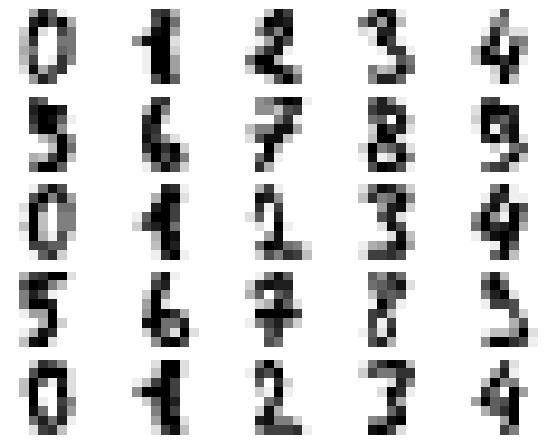

In [36]:
fig, ax_array = plt.subplots(5, 5)
axes = ax_array.flatten()
for i, ax in enumerate(axes):
    ax.imshow(digits.images[i], cmap='gray_r')
plt.setp(axes, xticks=[], yticks=[], frame_on=False)
plt.tight_layout(h_pad=0.5, w_pad=0.01)

In [37]:
tsne = TSNE(
    n_components=2, perplexity=30, init="pca", learning_rate="auto", random_state=0, verbose=True
)

In [38]:
embedding = tsne.fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1797 samples in 0.001s...
[t-SNE] Computed neighbors for 1797 samples in 0.393s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1797
[t-SNE] Computed conditional probabilities for sample 1797 / 1797
[t-SNE] Mean sigma: 11.585657
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.325920
[t-SNE] KL divergence after 1000 iterations: 0.753624


Text(0.5, 1.0, 'tSNE of the Digits dataset')

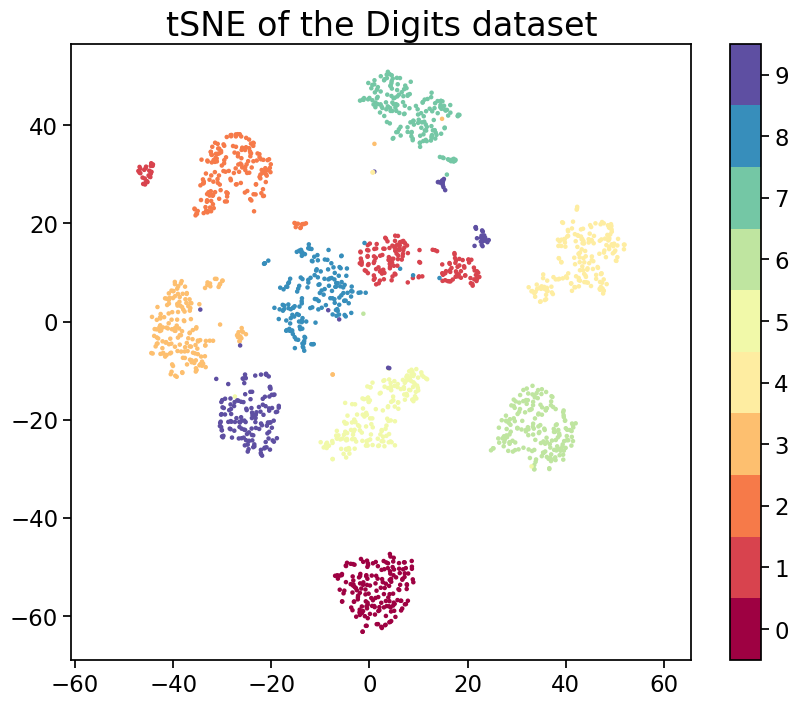

In [39]:
plt.figure(figsize=(10, 8))
plt.scatter(embedding[:, 0], embedding[:, 1], c=digits.target, cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('tSNE of the Digits dataset', fontsize=24)

`openTSNE`提供快速的實作和更多與t-SNE相關的最佳化，詳情請見 https://opentsne.readthedocs.io/en/latest/ 。

In [40]:
otsne = oTSNE(
    n_components=2,
    perplexity=30,
    initialization='pca',
    n_jobs=2,
    random_state=0,
    negative_gradient_method='auto',
    verbose=True,
)

In [41]:
embedding = otsne.fit(X)

--------------------------------------------------------------------------------
TSNE(early_exaggeration=12, n_jobs=2, random_state=0, verbose=True)
--------------------------------------------------------------------------------
===> Finding 90 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 1.78 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.22 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.07 seconds
===> Running optimization with exaggeration=12.00, lr=149.75 for 250 iterations...
Iteration   50, KL divergence 2.6221, 50 iterations in 3.2225 sec
Iteration  100, KL divergence 2.6242, 50 iterations in 2.0568 sec
Iteration  150, KL divergence 2.6107, 50 iterations in 1.5858 sec
Iteration  200, KL divergence 2.6051, 50 iterations in 1.6717 sec
Iteration  250, KL divergence 2.6027, 50 iterations in 1.9699 sec
   --> Time elapsed: 10.51 seconds
===> Running optimization with exaggeration=1.

Text(0.5, 1.0, 'tSNE of the Digits dataset')

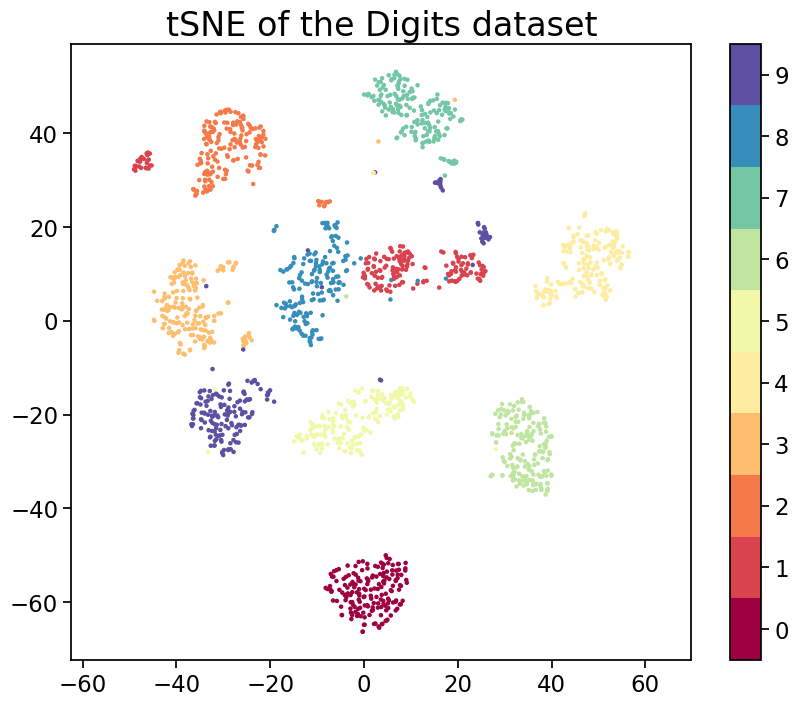

In [42]:
plt.figure(figsize=(10, 8))
plt.scatter(embedding[:, 0], embedding[:, 1], c=digits.target, cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('tSNE of the Digits dataset', fontsize=24)

### UMAP降維

UMAP對於生成視覺化很有用，但如果我們想在機器學習任務中更廣泛地使用UMAP，重要的是能夠訓練模型，然後稍後將新資料傳遞給模型，並讓它將該資料轉換到學習的空間中。例如，如果我們使用UMAP學習潛在空間，然後在轉換到潛在空間的資料上訓練分類器，那麼分類器只有在我們能夠將想要預測的資料轉換到分類器使用的潛在空間時，才對預測有用。

In [43]:
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, stratify=digits.target, random_state=42)

In [44]:
svc = SVC(gamma='auto').fit(X_train, y_train)
knn = KNeighborsClassifier().fit(X_train, y_train)
svc.score(X_test, y_test), knn.score(X_test, y_test)

(0.62, 0.9844444444444445)

現在的目標是將UMAP用作預處理步驟，可以潛在地整合到流水線中。

In [45]:
trans = umap.UMAP(n_neighbors=5, random_state=42).fit(X_train)

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Text(0.5, 1.0, 'Umap of the Digits dataset')

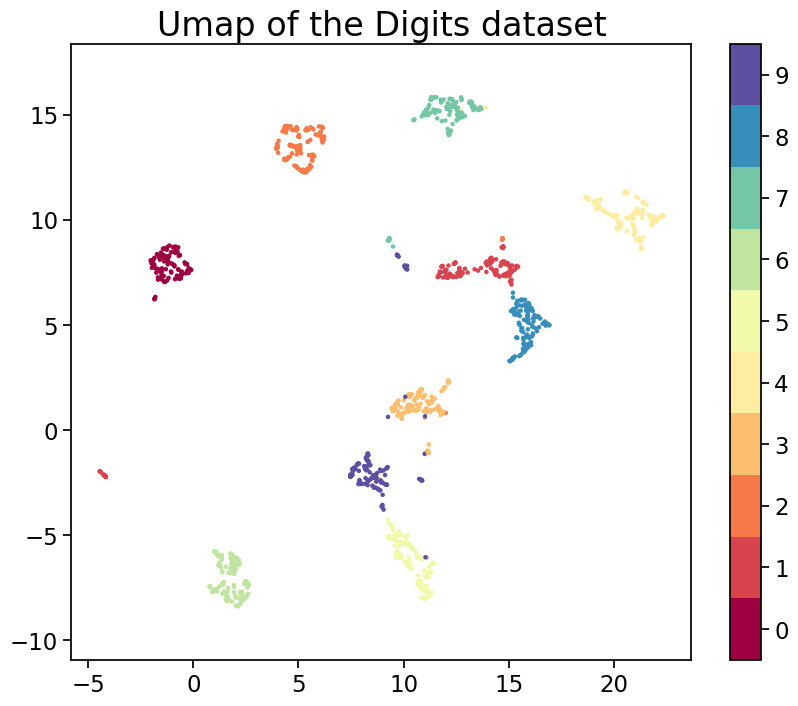

In [46]:
plt.figure(figsize=(10, 8))
plt.scatter(trans.embedding_[:, 0], trans.embedding_[:, 1], c=y_train, cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('Umap of the Digits dataset', fontsize=24)

這看起來非常有前景！大多數類別都得到了很乾淨的分離，這給了我們一些希望，它可能有助於分類器性能。我們現在可以在嵌入的訓練資料上訓練一些新模型（再次使用SVC和KNN分類器）。這看起來與之前完全相同，但現在我們傳遞嵌入的資料。

In [47]:
svc = SVC(gamma='auto').fit(trans.embedding_, y_train)
knn = KNeighborsClassifier().fit(trans.embedding_, y_train)

In [48]:
test_embedding = trans.transform(X_test)

下一個重要問題是我們的測試資料經過了什麼轉換。原則上我們有了測試集的新二維表示，理想情況下這應該基於現有的訓練集嵌入

Text(0.5, 1.0, 'Umap of the Digits dataset')

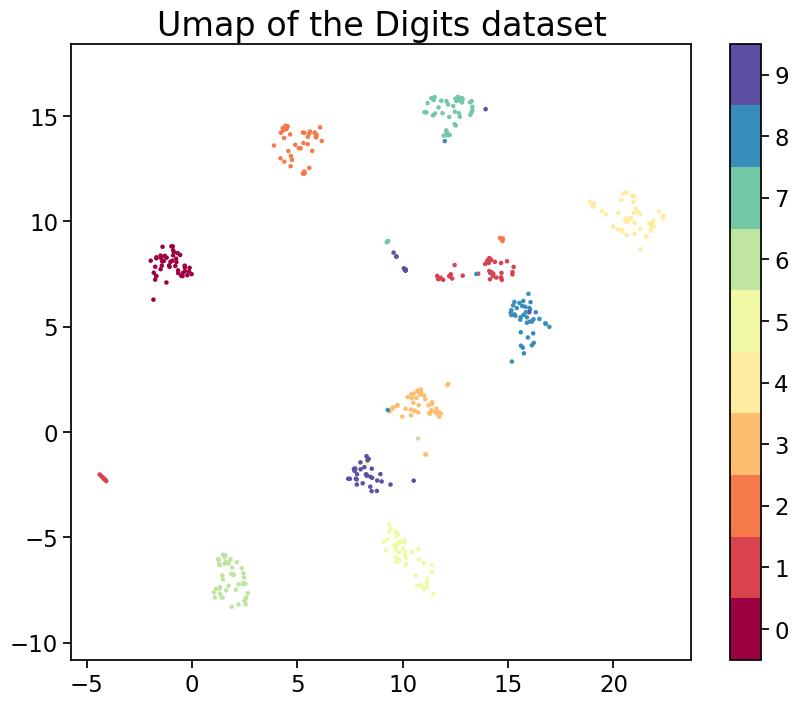

In [49]:
plt.figure(figsize=(10, 8))
plt.scatter(test_embedding[:, 0], test_embedding[:, 1], c=y_test, cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('Umap of the Digits dataset', fontsize=24)

結果看起來如我們所期望的；測試資料已經被嵌入到二維中，位置正是我們根據上面視覺化的訓練資料嵌入應該期望的（按類別）。這意味著我們現在可以通過將新轉換的測試集傳遞給在嵌入的訓練資料上訓練的模型來試用這些模型。

In [50]:
svc.score(trans.transform(X_test), y_test), knn.score(trans.transform(X_test), y_test)

(0.9822222222222222, 0.9822222222222222)

結果相當好。雖然KNN分類器的準確率沒有提升，但在給定資料的情況下，改進的空間不大。另一方面，SVC已經改進到與KNN分類器具有相等的準確率！

對於更有趣的資料集，更大維度的嵌入可能會有顯著的增益——在包含UMAP的流水線的網格搜尋中，這絕對值得作為參數之一來探索。

### PHATE降維

PHATE（基於親和力軌跡嵌入的勢熱擴散，Potential Heat-diffusion for Affinity-based Trajectory Embedding）是一個視覺化高維資料的工具。PHATE使用新穎的概念框架來學習和視覺化同時保持局部和全域距離的流形。

In [51]:
phate_op = phate.PHATE(n_components=2)
data_phate = phate_op.fit_transform(X)

Calculating PHATE...
  Running PHATE on 1797 observations and 64 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.09 seconds.
    Calculating affinities...
    Calculated affinities in 3.12 seconds.
  Calculated graph and diffusion operator in 3.23 seconds.
  Calculating optimal t...
    Automatically selected t = 26
  Calculated optimal t in 13.43 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 5.11 seconds.
  Calculating metric MDS...
    SGD-MDS may not have converged: stress changed by -3.1% in final iterations. Consider increasing n_iter or adjusting learning_rate.
  Calculated metric MDS in 9.65 seconds.
Calculated PHATE in 31.48 seconds.


Text(0.5, 1.0, 'phate of the Digits dataset')

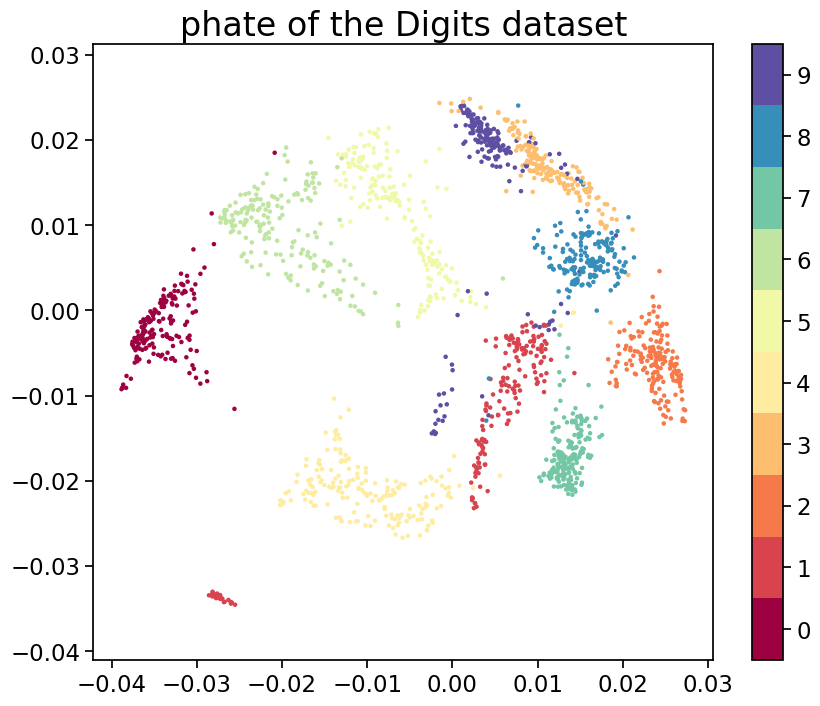

In [52]:
plt.figure(figsize=(10, 8))
plt.scatter(data_phate[:, 0], data_phate[:, 1], c=digits.target, cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('phate of the Digits dataset', fontsize=24)

## 聚類分析（Clustering）

### $K$-Means聚類分析

估計器`scikit-learn.cluster.KMeans()`在Python中執行$K$-means聚類。我們從一個簡單的模擬範例開始，其中資料確實有兩個聚類：前25個觀察值相對於後25個觀察值有均值偏移。

In [53]:
np.random.seed(0);
X = np.random.standard_normal((50,2));
X[:25,0] += 3;
X[:25,1] -= 4;

我們現在執行$K=2$的$K$-means聚類。

In [54]:
kmeans = KMeans(n_clusters=2,
                random_state=2,
                n_init=20).fit(X)

我們指定`random_state`以使結果可重現。50個觀察值的聚類指派包含在`kmeans.labels_`中。

In [55]:
kmeans.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1], dtype=int32)

$K$-means聚類完美地將觀察值分離成兩個
聚類，即使我們沒有向`KMeans()`提供任何分組資訊。我們可以繪製資料，每個觀察值
根據其聚類指派進行著色。

Text(0, 0.5, 'X1')

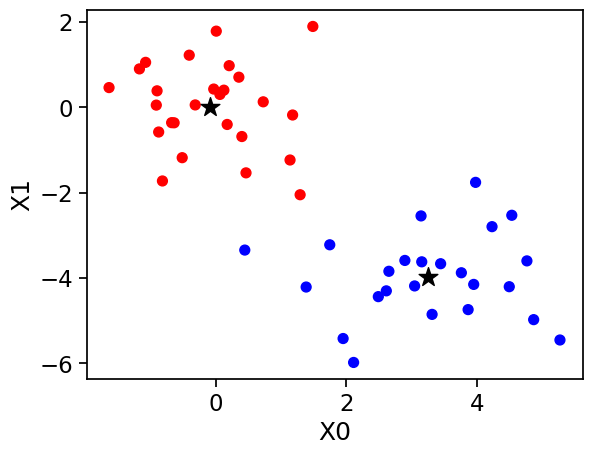

In [56]:
plt.scatter(X[:, 0], X[:, 1], c=kmeans.labels_, s=50, cmap=plt.cm.bwr)

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1],marker = '*', c='black', s=200, alpha=1)
plt.xlabel('X0')
plt.ylabel('X1')

這裡觀察值可以輕易地繪製，因為它們是
二維的。如果有超過兩個變數，那麼我們可以
改為執行PCA並繪製前兩個主成分分數向量來代表聚類。

在這個範例中，我們知道真的有兩個聚類，因為我們生成了資料。然而，對於真實資料，我們不知道聚類的真實數量，也不知道它們是否以任何精確的方式存在。我們也可以在這個範例上執行$K=3$的$K$-means聚類。

Text(0, 0.5, 'X1')

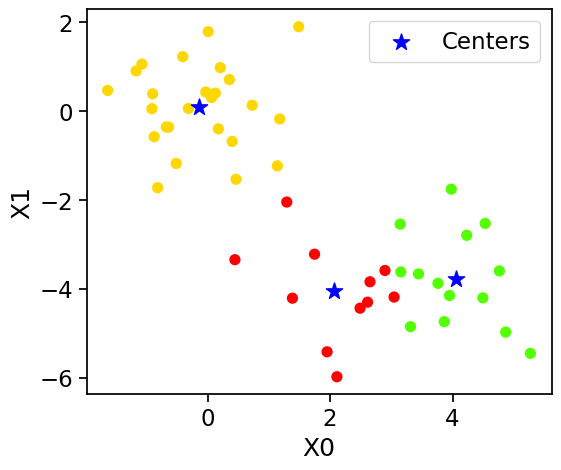

In [57]:
kmeans = KMeans(n_clusters=3,
                random_state=3,
                n_init=20).fit(X)
plt.figure(figsize=(6,5))
plt.scatter(X[:,0], X[:,1], s=50, c=kmeans.labels_, cmap=plt.cm.prism)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker='*', s=150,
            color='blue', label='Centers')
plt.legend(loc='best')
plt.xlabel('X0')
plt.ylabel('X1')

當$K=3$時，$K$-means聚類將兩個聚類分割開。
我們使用`n_init`參數來執行具有20個初始聚類指派的$K$-means（預設值為10）。如果使用大於1的`n_init`值，那麼$K$-means
聚類將使用演算法12.2步驟1中的多個隨機指派來執行，而`KMeans()`
函數將只報告最佳結果。這裡我們比較使用
`n_init=1`和`n_init=20`。

In [58]:
kmeans1 = KMeans(n_clusters=3,
                random_state=3,
                n_init=1).fit(X)
kmeans20 = KMeans(n_clusters=3,
                  random_state=3,
                  n_init=20).fit(X);
kmeans1.inertia_, kmeans20.inertia_

(76.85131986999251, 75.06261242745386)

注意：`kmeans.inertia_`是聚類內平方和的總和，
我們透過執行$K$-means
聚類來尋求最小化這個值(12.17)。

我們*強烈*建議總是以較大的`n_init`值（如20或50）運行$K$-means聚類，否則可能會獲得不理想的局部最優解。

在執行$K$-means聚類時，除了使用多個初始聚類指派外，使用`KMeans()`的`random_state`參數設定隨機種子也很重要。這樣，步驟1中的初始聚類指派可以被複製，$K$-means輸出將完全可重現。

### 階層式聚類（Hierarchical Clustering）

`scikit-learn.clustering`套件中的`AgglomerativeClustering()`類別實現了階層式聚類。
由於其名稱較長，我們使用*階層式聚類*的簡寫`HClust`。注意：這不會改變使用此方法時的回傳類型，所以實例仍然是`AgglomerativeClustering`類別。
在以下範例中，我們使用前一個實驗的資料來繪製階層式聚類樹狀圖，使用完全連結、單一連結和平均連結聚類，以歐幾里得距離作為相異性度量。我們首先使用完全連結對觀察值進行聚類。

In [59]:
HClust = AgglomerativeClustering
hc_comp = HClust(distance_threshold=0,
                 n_clusters=None,
                 linkage='complete')
hc_comp.fit(X)

AgglomerativeClustering(distance_threshold=0, linkage='complete',
                        n_clusters=None)

這會計算整棵階層式樹狀圖（dendrogram）。
我們也可以選擇使用階層式分群中的 average linkage（平均連接）或 single linkage（單一連接）等方式來進行分群。


In [60]:
hc_avg = HClust(distance_threshold=0,
                n_clusters=None,
                linkage='average');
hc_avg.fit(X)
hc_sing = HClust(distance_threshold=0,
                 n_clusters=None,
                 linkage='single');
hc_sing.fit(X);

使用預先計算好的距離矩陣時，我們需要額外提供參數 `metric="precomputed"`。
在下方程式碼中，前四行會計算出一個 $50\times 50$ 的兩兩距離矩陣。


In [61]:
D = np.zeros((X.shape[0], X.shape[0]));
for i in range(X.shape[0]):
    x_ = np.multiply.outer(np.ones(X.shape[0]), X[i])
    D[i] = np.sqrt(np.sum((X - x_)**2, 1));
hc_sing_pre = HClust(distance_threshold=0,
                     n_clusters=None,
                     metric='precomputed',
                     linkage='single')
hc_sing_pre.fit(D)

AgglomerativeClustering(distance_threshold=0, linkage='single',
                        metric='precomputed', n_clusters=None)

我們使用 `scipy.cluster.hierarchy` 套件中的 `dendrogram()` 函式來繪製階層式樹狀圖（dendrogram）。
然而，`dendrogram()` 需要的是所謂的**連接矩陣（linkage matrix）表示法**，這並不是 `AgglomerativeClustering()` 所直接提供的結果，但可以額外計算取得。
[`ISLP.cluster`](https://islp.readthedocs.io/en/latest/helpers/cluster.html) 套件中的 `compute_linkage()` 函式就是為了這個目的所設計的。

接下來我們可以開始繪製 dendrogram。圖中下方的數字表示每筆觀測資料的編號。
`dendrogram()` 函式預設會使用某個方法將不同分支上色，暗示在特定深度可以切割出預設的群集結果。
我們傾向關閉這個預設行為，方式是將該閾值設定為無限大（infinite）。
由於我們可能會繪製多張 dendrogram，因此我們將這些設定存成一個字典 `cargs`，並透過 `**cargs` 的語法以關鍵字參數形式傳入。


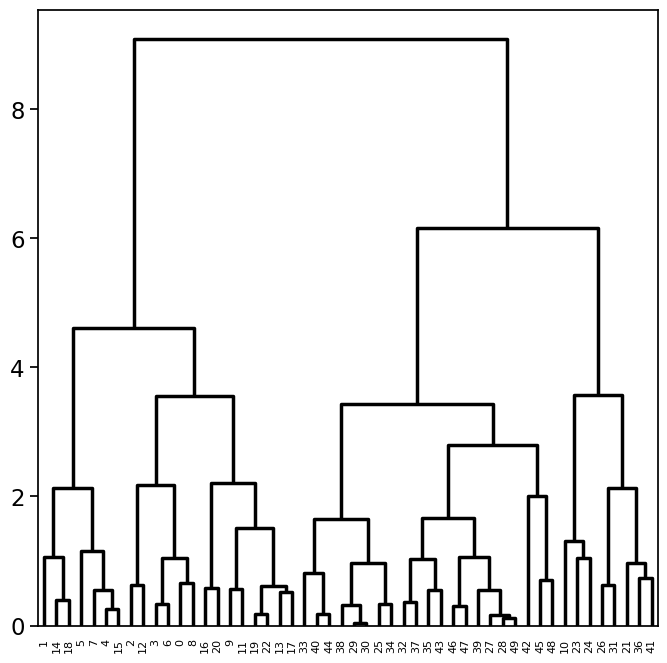

In [62]:
cargs = {'color_threshold':-np.inf,
         'above_threshold_color':'black'}
linkage_comp = compute_linkage(hc_comp)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
dendrogram(linkage_comp,
           ax=ax,
           **cargs);

我們可能希望將樹狀圖中高於與低於切割閾值的分支以不同顏色顯示。
這可以透過調整 `color_threshold` 參數來達成。
例如，若我們想在高度為 4 的位置切割樹，並將所有在高度 4 以上（即合併發生在此高度以上）的連線標示為黑色，則可如下設定。


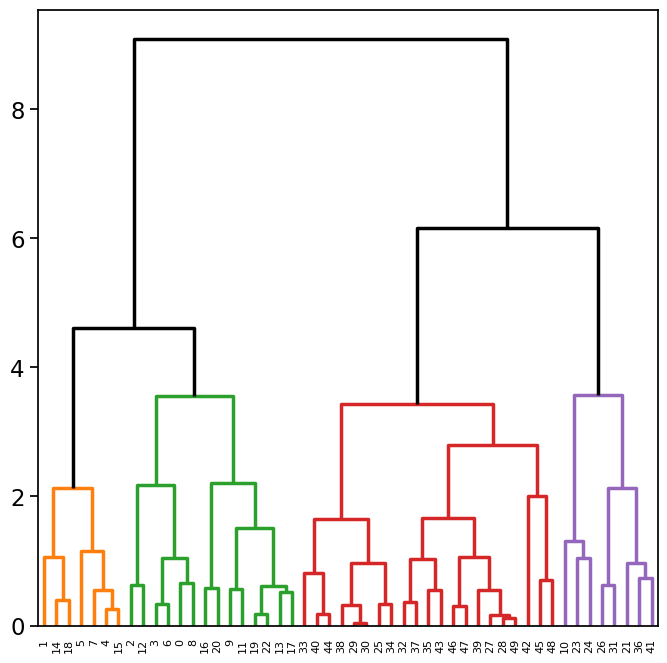

In [63]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
dendrogram(linkage_comp,
           ax=ax,
           color_threshold=4,
           above_threshold_color='black');

若要根據 dendrogram 的特定切割高度來決定每筆觀測資料所屬的群集標籤，我們可以使用 `scipy.cluster.hierarchy` 中的 `cut_tree()` 函式來達成：


In [64]:
cut_tree(linkage_comp, n_clusters=4).T

array([[0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 2, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 2,
        0, 2, 2, 3, 2, 3, 3, 3, 3, 2, 3, 3, 3, 3, 2, 3, 3, 3, 3, 2, 3, 3,
        3, 3, 3, 3, 3, 3]])

這也可以透過在 `HClust()` 中提供參數 `n_clusters` 來達成；
然而，每次切割都需要重新執行分群。

同樣地，也可以透過提供 `distance_threshold` 給 `HClust()`，或是提供 `height` 給 `cut_tree()`，
以距離閾值的方式對樹進行切割。


In [65]:
cut_tree(linkage_comp, height=5)

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [2],
       [1],
       [2],
       [2],
       [2],
       [2],
       [1],
       [2],
       [2],
       [2],
       [2],
       [1],
       [2],
       [2],
       [2],
       [2],
       [1],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2]])

在對觀測資料進行階層式分群之前，我們可以先對變數進行標準化處理，
這可使用與主成分分析（PCA）範例中相同的 `StandardScaler()` 來完成：


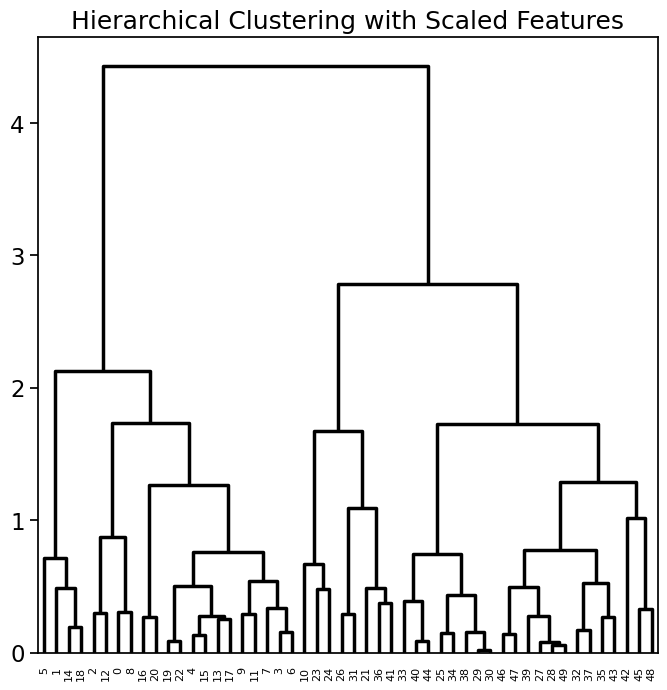

In [66]:
scaler = StandardScaler()
X_scale = scaler.fit_transform(X)
hc_comp_scale = HClust(distance_threshold=0,
                       n_clusters=None,
                       linkage='complete').fit(X_scale)
linkage_comp_scale = compute_linkage(hc_comp_scale)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
dendrogram(linkage_comp_scale, ax=ax, **cargs)
ax.set_title("Hierarchical Clustering with Scaled Features");

以觀測值之間的相關性為基礎計算距離，可以用於分群。
兩個觀測值之間的相關係數可用來衡量其特徵數值的相似程度。
（假設每個觀測值具有 $p$ 個數值型特徵，我們可透過這 $p$ 對數字之間的相關性來衡量兩筆觀測資料的相似度。）

對於 $n$ 筆觀測值，我們可以計算出一個 $n \times n$ 的相關係數矩陣，將其視為**相似度矩陣**（similarity 或 affinity matrix）；
而將「1 減去該相關係數矩陣」則可作為**不相似度矩陣**（dissimilarity matrix），用於分群分析。

**注意**:僅當資料至少具有三個特徵時，使用相關係數才有意義，
因為若觀測值僅含兩個特徵，任意兩筆觀測值之間的絕對相關係數一定為 1。
因此，我們將使用具有三維特徵的資料集進行分群分析。


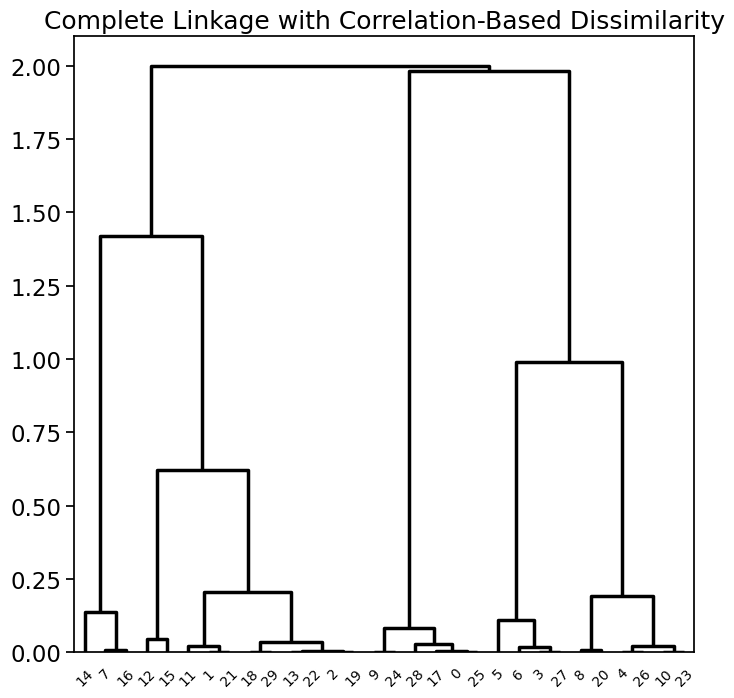

In [67]:
X = np.random.standard_normal((30, 3))
corD = 1 - np.corrcoef(X)
hc_cor = HClust(linkage='complete',
                distance_threshold=0,
                n_clusters=None,
                metric='precomputed')
hc_cor.fit(corD)
linkage_cor = compute_linkage(hc_cor)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
dendrogram(linkage_cor, ax=ax, **cargs)
ax.set_title("Complete Linkage with Correlation-Based Dissimilarity");

你可以在 [http://danifold.net/fastcluster.html](http://danifold.net/fastcluster.html) 取得一個更高效的實作版本。其用法與 `Scipy` 相同。


In [68]:
lk = fc.linkage(X, method='complete', metric='correlation', preserve_input=True)

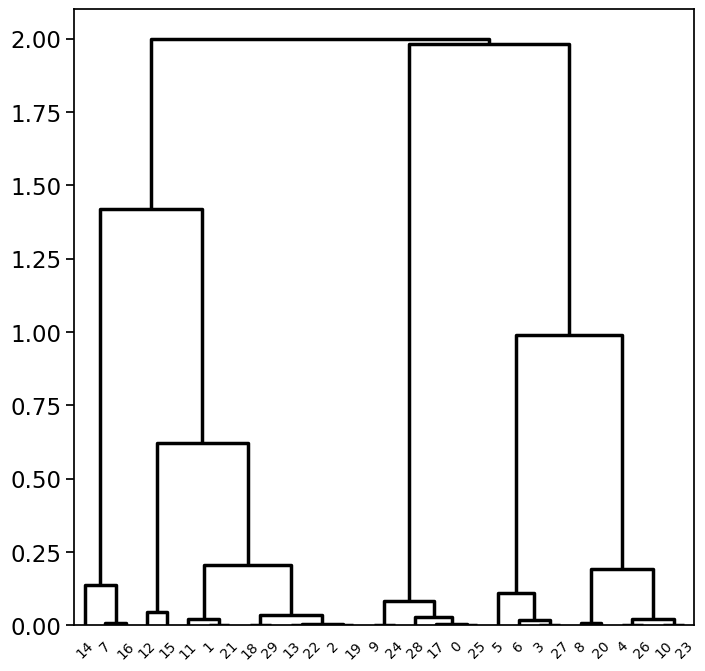

In [69]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
dendrogram(lk, ax=ax, **cargs);

### DBSCAN


In [70]:
# Generate sample data
centers = [[1, 1], [-1, -1], [1, -1]]
X, labels_true = make_blobs(
    n_samples=750, centers=centers, cluster_std=0.4, random_state=0
)

X = StandardScaler().fit_transform(X)

更多有關分群效能評估的指標與方法，請參見：
https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation


In [71]:
# Compute DBSCAN
db = DBSCAN(eps=0.3, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true, labels))
print(
    "Adjusted Mutual Information: %0.3f"
    % metrics.adjusted_mutual_info_score(labels_true, labels)
)

Estimated number of clusters: 3
Estimated number of noise points: 18
Homogeneity: 0.953
Completeness: 0.883
V-measure: 0.917
Adjusted Rand Index: 0.952
Adjusted Mutual Information: 0.916


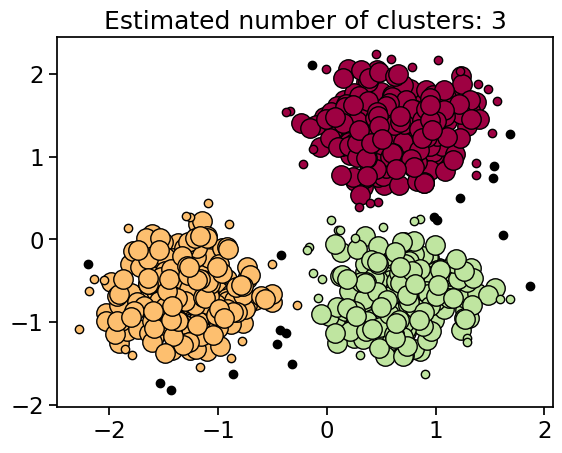

In [72]:
# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title("Estimated number of clusters: %d" % n_clusters_);

然而，DBSCAN 對於超參數設定相當敏感。


In [73]:
# Generate sample data
centers = [[0, 0], [5, 5]]
X, labels_true = make_blobs(
    n_samples=500, centers=centers, cluster_std=[2.0,0.5], random_state=0
)

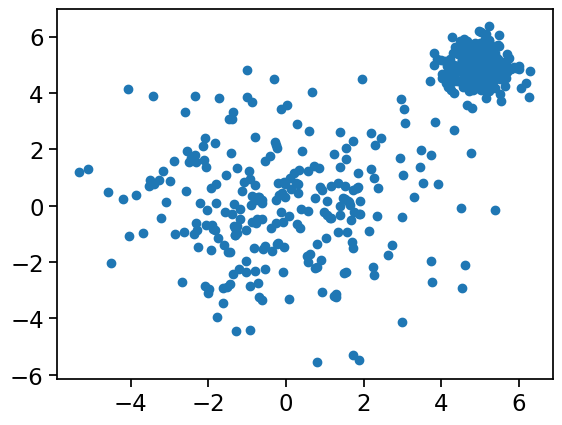

In [74]:
plt.scatter(X[:,0], X[:,1]);

In [75]:
epss = [2,2,3,3]
min_sampless = [50,100,50,100]

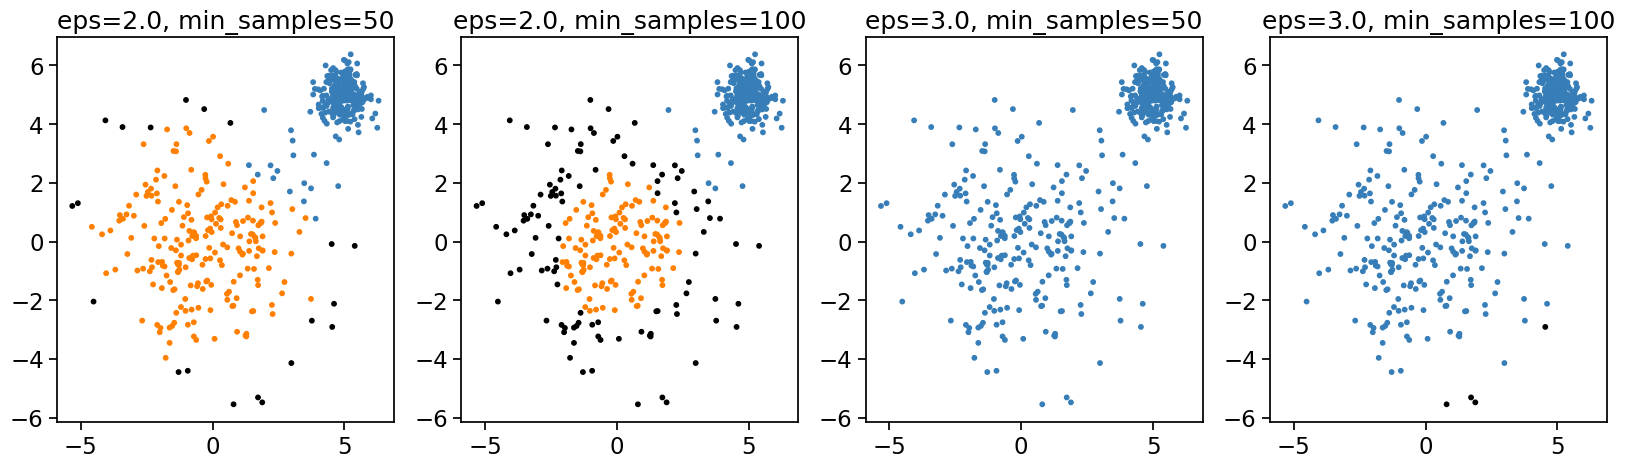

In [77]:
f, axes = plt.subplots(1, 4, sharex=False, sharey=False, figsize=(20,5))

for i in range(4):
  db = DBSCAN(eps=epss[i], min_samples=min_sampless[i]).fit(X)
  y_pred = db.labels_.astype(int)
  colors = np.array(
            list(
                islice(
                    cycle(
                        [
                            "#377eb8",
                            "#ff7f00",
                            "#4daf4a",
                            "#f781bf",
                            "#a65628",
                            "#984ea3",
                            "#999999",
                            "#e41a1c",
                            "#dede00",
                        ]
                    ),
                    int(max(y_pred) + 1),
                )
            )
        )
  # add black color for outliers (if any)
  colors = np.append(colors, ["#000000"])
  axes[i].scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

  axes[i].set_title("eps=%.1f, min_samples=%d" % (epss[i],min_sampless[i]));

我們可以嘗試使用 HDBSCAN 作為替代方法。
更多資訊請參考：[https://hdbscan.readthedocs.io/en/latest/index.html](https://hdbscan.readthedocs.io/en/latest/index.html)

In [78]:
min_cluster_sizes = [5,10,30,50]

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12

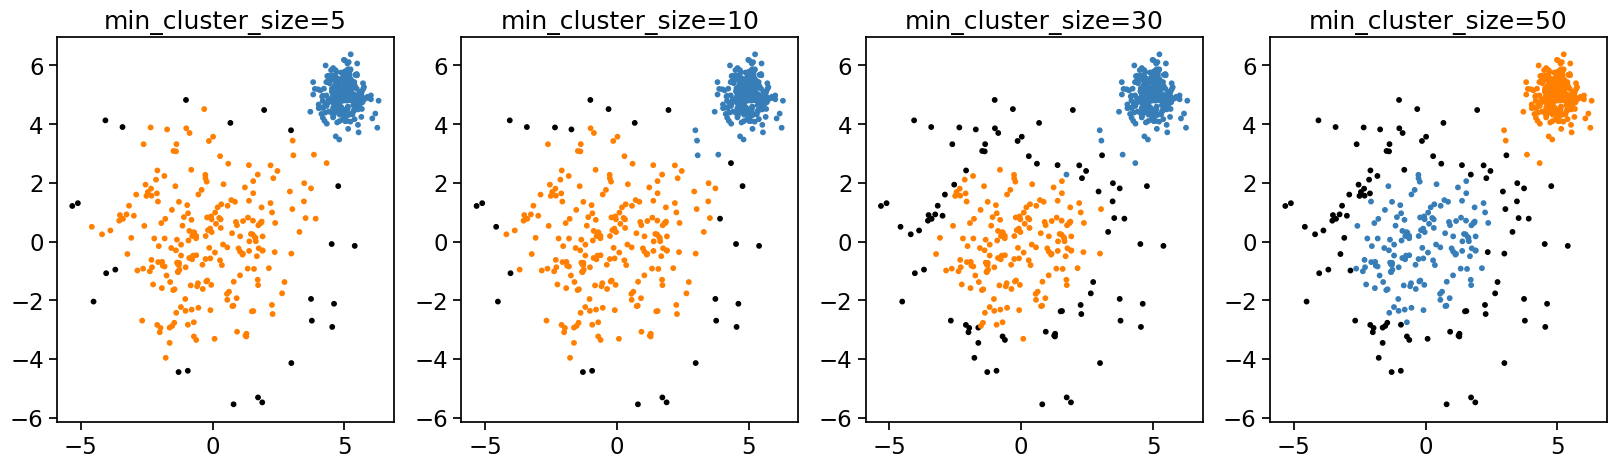

In [79]:
f, axes = plt.subplots(1, 4, sharex=False, sharey=False, figsize=(20,5))

for i in range(4):
  db = hdbscan.HDBSCAN(min_cluster_size=min_cluster_sizes[i]).fit(X)
  y_pred = db.labels_.astype(int)
  colors = np.array(
            list(
                islice(
                    cycle(
                        [
                            "#377eb8",
                            "#ff7f00",
                            "#4daf4a",
                            "#f781bf",
                            "#a65628",
                            "#984ea3",
                            "#999999",
                            "#e41a1c",
                            "#dede00",
                        ]
                    ),
                    int(max(y_pred) + 1),
                )
            )
        )
  # add black color for outliers (if any)
  colors = np.append(colors, ["#000000"])
  axes[i].scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])
  axes[i].set_title("min_cluster_size=%d" % (min_cluster_sizes[i]))

## NCI60資料範例

無監督技術經常用於基因組資料分析。特別是PCA和階層式聚類是熱門工具。我們在[`NCI60`](https://islp.readthedocs.io/en/latest/datasets/NCI60.html)癌症細胞株微陣列資料上說明這些技術，該資料包含64個癌症細胞株上的6830個基因表現測量。

In [80]:
NCI60 = load_data('NCI60')
nci_labs = NCI60['labels']
nci_data = NCI60['data']

每個細胞株都標有癌症類型。我們在執行PCA和聚類時不使用
這些癌症類型，因為這些是
無監督技術。但在執行PCA和聚類後，我們
將檢查這些癌症類型與這些無監督技術的結果在多大程度上一致。

資料有64行和6830列。

In [81]:
nci_data.shape

(64, 6830)

我們首先檢視細胞株的癌症類型。

In [82]:
nci_labs.value_counts()

,count
label,
RENAL,9
NSCLC,9
MELANOMA,8
BREAST,7
COLON,7
LEUKEMIA,6
OVARIAN,6
CNS,5
PROSTATE,2


### 對NCI60資料進行PCA

我們首先在將變數（基因）縮放到標準差為1後對資料執行PCA，儘管在這裡可以合理地論證不縮放基因更好，因為它們是以相同單位測量的。

In [83]:
scaler = StandardScaler()
nci_scaled = scaler.fit_transform(nci_data)
nci_pca = PCA()
nci_scores = nci_pca.fit_transform(nci_scaled)

我們現在繪製前幾個主成分分數向量，以視覺化資料。對應於給定癌症類型的觀察值（細胞株）將以相同顏色繪製，這樣我們可以
看到癌症類型內觀察值彼此相似的程度。

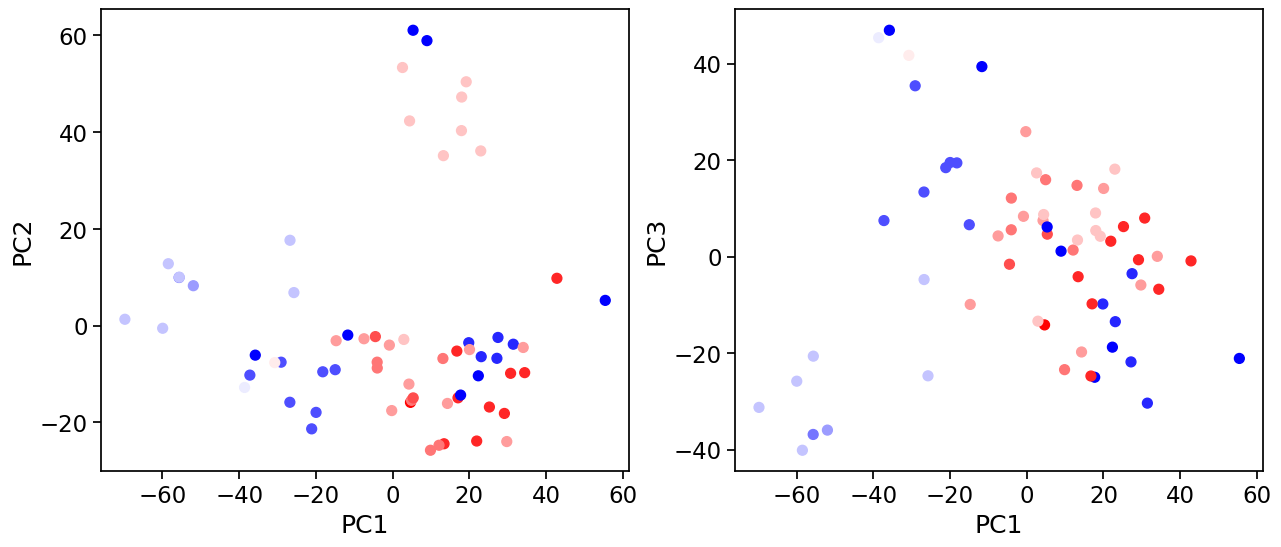

In [84]:
cancer_types = list(np.unique(nci_labs))
nci_groups = np.array([cancer_types.index(lab)
                       for lab in nci_labs.values])
fig, axes = plt.subplots(1, 2, figsize=(15,6))
ax = axes[0]
ax.scatter(nci_scores[:,0],
           nci_scores[:,1],
           c=nci_groups,
           marker='o',
           s=50, cmap=plt.cm.bwr)
ax.set_xlabel('PC1'); ax.set_ylabel('PC2')
ax = axes[1]
ax.scatter(nci_scores[:,0],
           nci_scores[:,2],
           c=nci_groups,
           marker='o',
           s=50, cmap=plt.cm.bwr)
ax.set_xlabel('PC1'); ax.set_ylabel('PC3');

總的來說，對應於單一癌症類型的細胞株確實傾向於在前幾個主成分分數向量上有相似的值。這表明來自相同癌症類型的細胞株傾向於有相當相似的基因表現水準。




我們也可以繪製主成分解釋的變異數百分比以及累積變異數百分比解釋。
這類似於我們之前為`USArrests`資料製作的圖表。

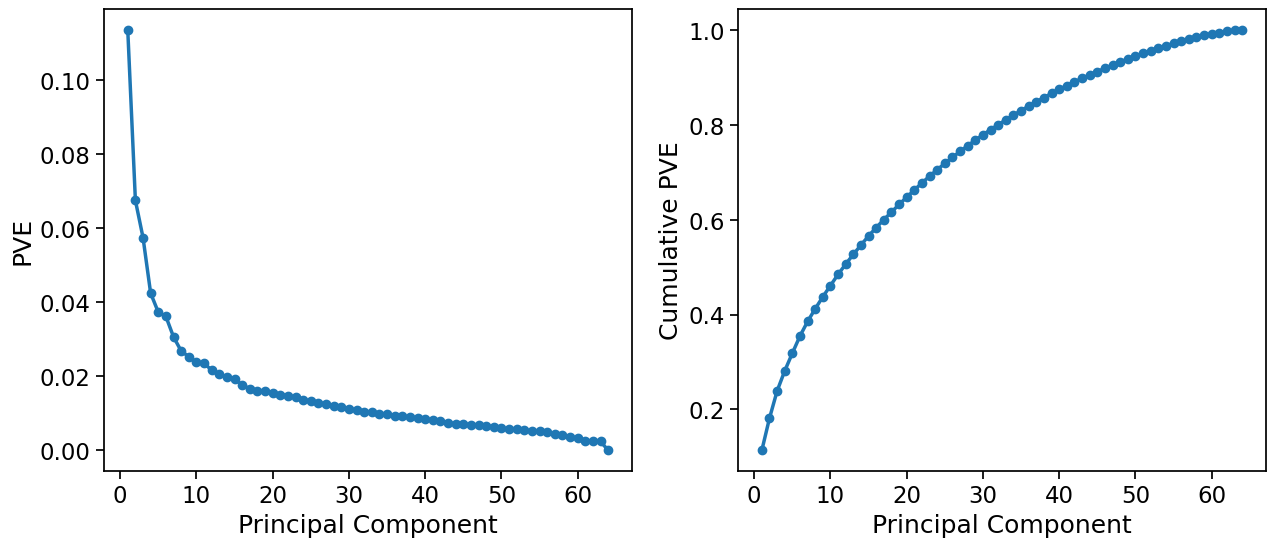

In [85]:
fig, axes = plt.subplots(1, 2, figsize=(15,6))
ax = axes[0]
ticks = np.arange(nci_pca.n_components_)+1
ax.plot(ticks,
        nci_pca.explained_variance_ratio_,
        marker='o')
ax.set_xlabel('Principal Component');
ax.set_ylabel('PVE')
ax = axes[1]
ax.plot(ticks,
        nci_pca.explained_variance_ratio_.cumsum(),
        marker='o');
ax.set_xlabel('Principal Component')
ax.set_ylabel('Cumulative PVE');

我們看到，前七個主成分一起解釋了資料中約40%的變異數。這並不是大量的變異數。然而，看碎石圖，我們看到雖然前七個主成分中的每一個都解釋了大量變異數，但進一步的主成分解釋的變異數明顯減少。也就是說，在大約第七個主成分之後，圖中出現了*轉折點*。這表明檢視超過七個左右的主成分可能沒有多少好處（儘管即使檢視七個主成分可能都很困難）。

### 對NCI60資料的觀察值進行聚類

我們現在使用完全、單一和平均連結對`NCI60`資料中的細胞株進行階層式聚類。再次，目標是找出觀察值是否聚集成不同的癌症類型。歐幾里得距離用作相異性度量。我們首先編寫一個簡短的函數來產生三個樹狀圖。

In [86]:
def plot_nci(linkage, ax, cut=-np.inf):
    cargs = {'above_threshold_color':'black',
             'color_threshold':cut}
    hc = HClust(n_clusters=None,
                distance_threshold=0,
                linkage=linkage.lower()).fit(nci_scaled)
    linkage_ = compute_linkage(hc)
    dendrogram(linkage_,
               ax=ax,
               labels=np.asarray(nci_labs),
               leaf_font_size=10,
               **cargs)
    ax.set_title('%s Linkage' % linkage)
    return hc

讓我們來將結果繪製出來。


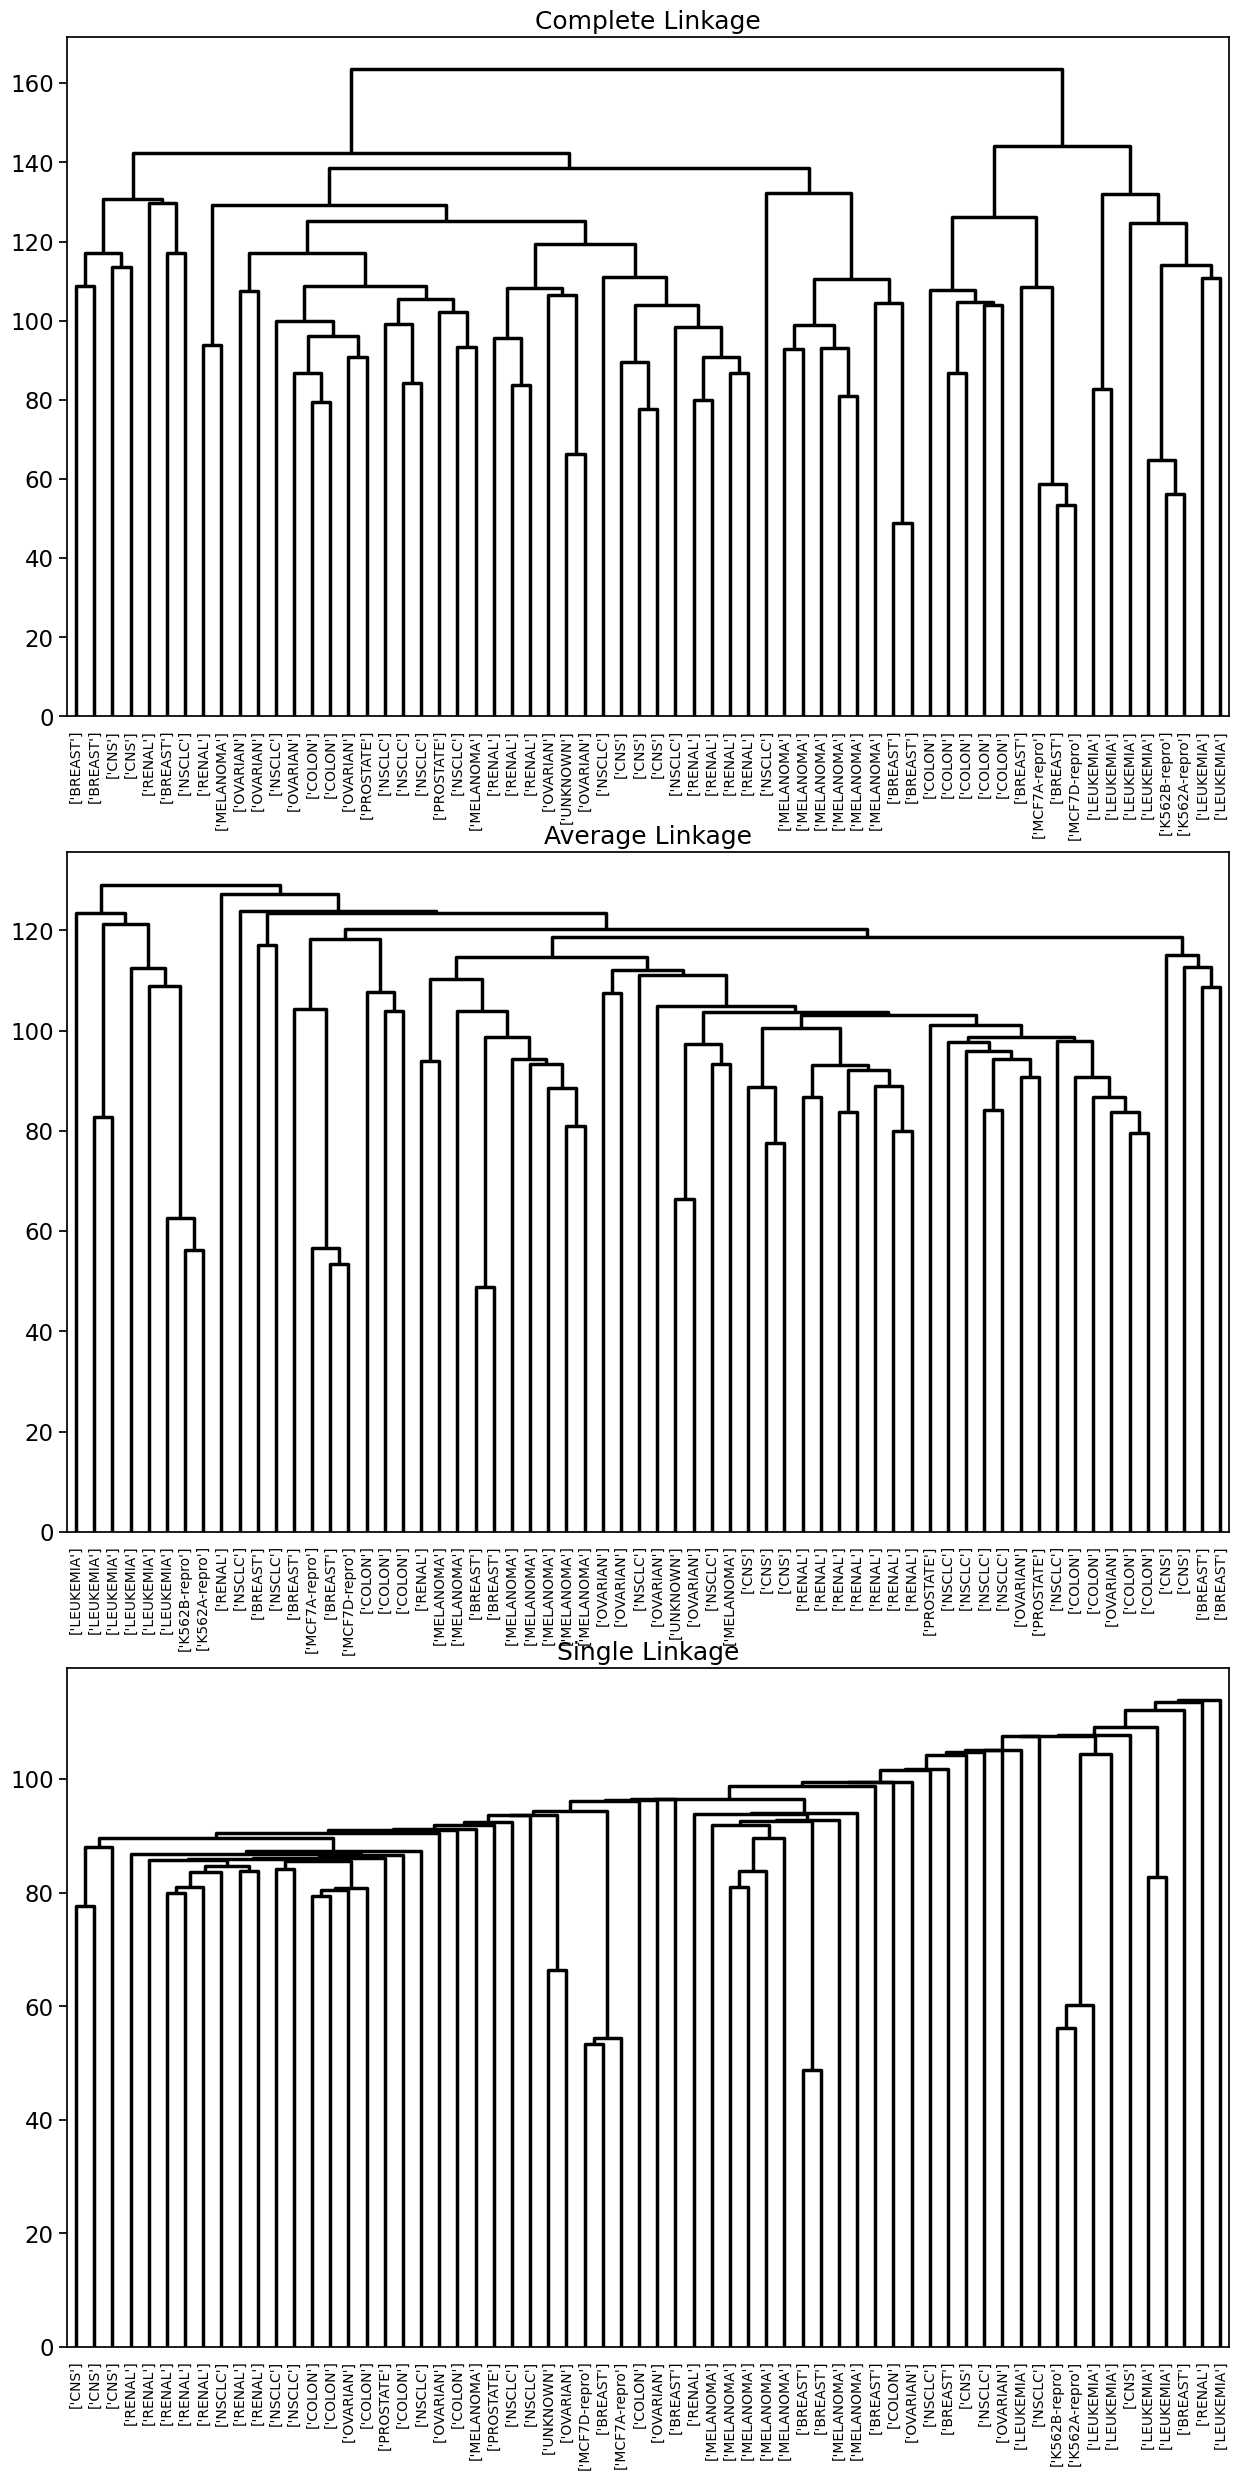

In [87]:
fig, axes = plt.subplots(3, 1, figsize=(15,30))
ax = axes[0]; hc_comp = plot_nci('Complete', ax)
ax = axes[1]; hc_avg = plot_nci('Average', ax)
ax = axes[2]; hc_sing = plot_nci('Single', ax)

我們可以觀察到，**連接方式（linkage）的選擇確實會影響最終的分群結果**。
通常情況下，**single linkage（單一連接）** 容易產生「拖尾型（trailing）」分群：
也就是形成一個非常大的主群集，其他觀測值則逐一附加上去。

相對地，**complete linkage（完全連接）** 和 **average linkage（平均連接）**
則更容易產生結構較平衡、形狀較吸引人的群集。
因此，在實務上我們通常偏好使用 complete 或 average linkage，而非 single linkage。

雖然某些相同癌症類型的細胞株傾向聚集在一起，但分群結果仍非完美。
因此在接下來的分析中，我們將採用complete linkage 的階層式分群方法。

我們也可以選擇在 dendrogram 中設定一個特定的高度來切割，
以獲得指定數量的群集，例如：四個群集。


In [88]:
linkage_comp = compute_linkage(hc_comp)
comp_cut = cut_tree(linkage_comp, n_clusters=4).reshape(-1)
pd.crosstab(nci_labs['label'],
            pd.Series(comp_cut.reshape(-1), name='Complete'))

Complete,0,1,2,3
label,,,,
BREAST,2,3,0,2
CNS,3,2,0,0
COLON,2,0,0,5
K562A-repro,0,0,1,0
K562B-repro,0,0,1,0
LEUKEMIA,0,0,6,0
MCF7A-repro,0,0,0,1
MCF7D-repro,0,0,0,1
MELANOMA,8,0,0,0


這裡可以觀察到一些明顯的模式：所有白血病細胞株都落在同一個群集中，而乳癌細胞株則分散在三個不同的群集中。

我們可以在 dendrogram 上繪製一條切割線，以產生這四個群集：


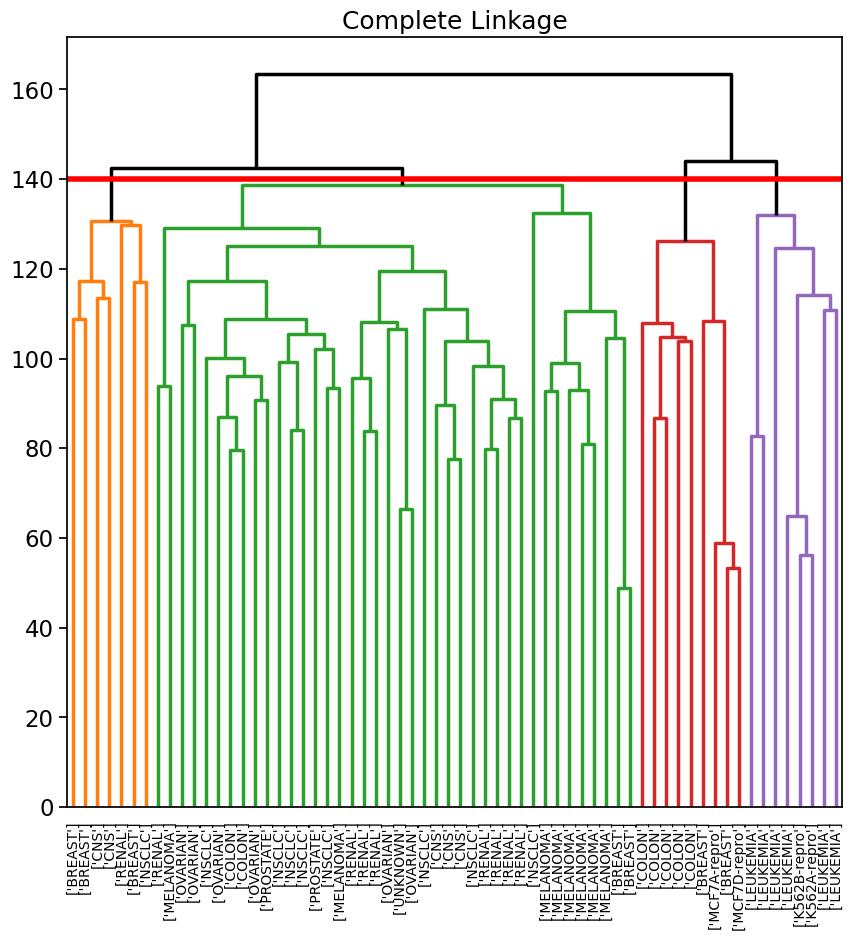

In [89]:
fig, ax = plt.subplots(figsize=(10,10))
plot_nci('Complete', ax, cut=140)
ax.axhline(140, c='r', linewidth=4);

`axhline()` 函式會在現有座標軸上畫出一條水平線。
在這裡，參數 `140` 會在 dendrogram 上的高度 140 處繪製一條水平線；這個高度對應切出四個明確群集的切割點。
這樣的分群結果很容易驗證，與我們先前在 `comp_cut` 中所得到的群集相同。

我們在第 12.4.2 節曾提到，
即使 $K$-means 分群與階層式分群的 dendrogram 切割產生相同數量的群集，
其分群結果可能會非常不同。

那麼，我們現在的 `NCI60` 階層式分群結果，與若使用 $K$-means 且 $K=4$ 時相比，會有什麼差異呢？


In [90]:
nci_kmeans = KMeans(n_clusters=4,
                    random_state=0,
                    n_init=20).fit(nci_scaled)
pd.crosstab(pd.Series(comp_cut, name='HClust'),
            pd.Series(nci_kmeans.labels_, name='K-means'))

K-means,0,1,2,3
HClust,,,,
0,1,20,10,9
1,0,7,0,0
2,8,0,0,0
3,0,0,9,0


我們可以看到，使用階層式分群與 $K$-means 分群所得到的四個群集略有不同。
首先需要注意的是，兩種分群方法中群集的標籤是任意的，
也就是說，即使群集的編號（identifier）對調，實際分群結果並不會改變。

例如，$K$-means 中的第 3 群與階層式分群中的第 2 群是完全相同的。
然而，其他群集則有所差異：
例如，$K$-means 中的第 0 群同時包含階層式分群中第 0 群的一部分觀測值，
以及階層式分群中全部被指派為第 1 群的觀測值。

除了針對整份資料矩陣執行階層式分群外，
我們也可以選擇先取前幾個主成分分數向量進行階層式分群，
因為這些主成分可視為原始資料的低雜訊版本（less noisy version）。

Complete-PCA,0,1,2,3
label,,,,
BREAST,0,5,0,2
CNS,2,3,0,0
COLON,7,0,0,0
K562A-repro,0,0,1,0
K562B-repro,0,0,1,0
LEUKEMIA,2,0,4,0
MCF7A-repro,0,0,0,1
MCF7D-repro,0,0,0,1
MELANOMA,1,7,0,0


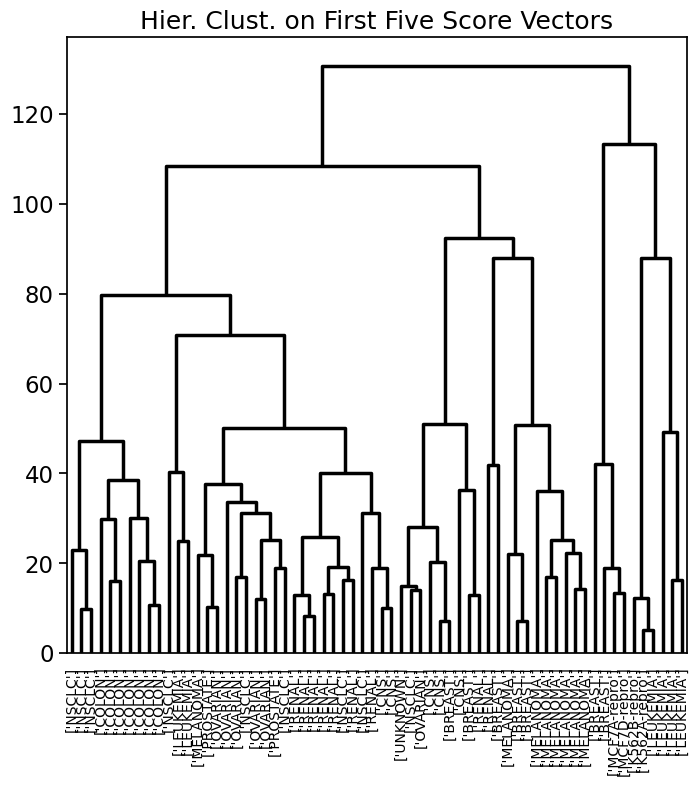

In [91]:
hc_pca = HClust(n_clusters=None,
                distance_threshold=0,
                linkage='complete'
                ).fit(nci_scores[:,:5])
linkage_pca = compute_linkage(hc_pca)
fig, ax = plt.subplots(figsize=(8,8))
dendrogram(linkage_pca,
           labels=np.asarray(nci_labs),
           leaf_font_size=10,
           ax=ax,
           **cargs)
ax.set_title("Hier. Clust. on First Five Score Vectors")
pca_labels = pd.Series(cut_tree(linkage_pca,
                                n_clusters=4).reshape(-1),
                       name='Complete-PCA')
pd.crosstab(nci_labs['label'], pca_labels)